<a href="https://colab.research.google.com/github/AlishaMomin/CUDA_Spring2022_GoogleColabs/blob/main/Cartoonify_Image_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /usr/local/
!rm -rf cuda
!ln -s /usr/local/cuda-10.0 /usr/local/cuda
!stat cuda
%cd /content

/usr/local
  File: cuda -> /usr/local/cuda-10.0
  Size: 20        	Blocks: 0          IO Block: 4096   symbolic link
Device: 24h/36d	Inode: 4991884     Links: 1
Access: (0777/lrwxrwxrwx)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2022-04-12 09:59:34.783180735 +0000
Modify: 2022-04-12 09:59:34.683181101 +0000
Change: 2022-04-12 09:59:34.683181101 +0000
 Birth: -
/content


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
from skimage import io
from PIL import Image
image = Image.fromarray(io.imread("https://placekitten.com/800/571"))
image.save("kitten.png")

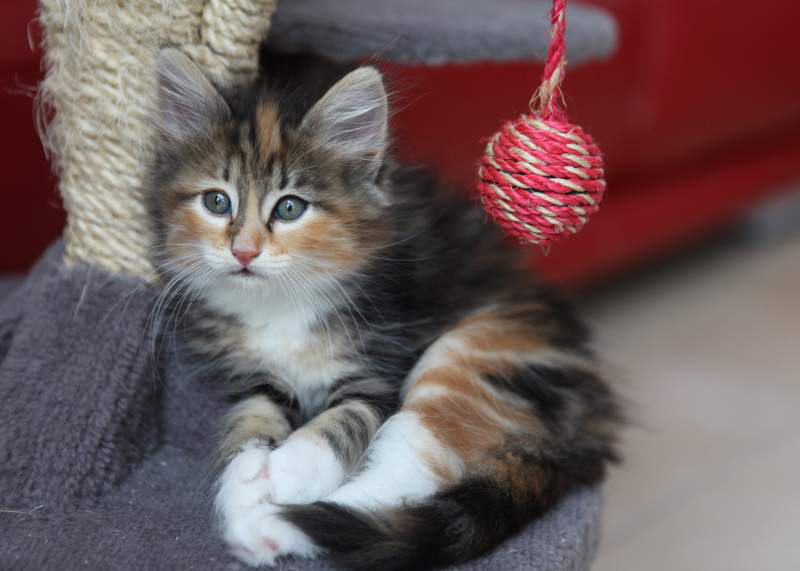

In [4]:
# checking 
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("kitten.png")
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
%%writefile cartoonify.cu
#include <stdio.h>
#include <cuda.h>
#include <iostream>
#include <opencv2/imgproc.hpp>
#include <opencv2/imgcodecs.hpp>
#include <opencv2/highgui.hpp>
#include <opencv2/core/core.hpp>
#include<opencv2/imgproc.hpp>
#include<opencv2/photo.hpp>

using namespace cv;
using namespace std;
using namespace cv::cuda;

void load_image(const Mat image)
{
  if (image.empty()) {
      cerr << "Couldn't open file: \n" << endl;
      exit(1);
  }
 else{
     cout<<"Image read\n";
 }
}
void grey_to_blur(const Mat image){
    Mat grayImage;
    cvtColor(image, grayImage, COLOR_BGR2GRAY);

		GaussianBlur(grayImage, grayImage, Size(3, 3), 0);
		Mat edgeImage;
    Laplacian(grayImage, edgeImage, -1, 5);
    convertScaleAbs(edgeImage, edgeImage);

    edgeImage = 255 - edgeImage;

    threshold(edgeImage, edgeImage, 150, 255, THRESH_BINARY);

    Mat edgePreservingImage;
    edgePreservingFilter(image, edgePreservingImage, 2, 50, 0.4);

    Mat output;
    output = Scalar::all(0);

    cv::bitwise_and(edgePreservingImage, edgePreservingImage, output, edgeImage);
		imwrite("cartoon.png", output);

}

//https://stackoverflow.com/questions/53699915/how-to-find-why-a-cuda-opencv-program-is-returning-a-plain-grey-image
int main()
{	
    Mat image;
    image = cv::imread("kitten.png");
    load_image(image);
 
    clock_t clk;
    clk = clock();
    grey_to_blur(image);
    clk = clock() - clk;
    double dt = (((double)clk) / CLOCKS_PER_SEC) * 1000;
    printf("The elapsed time in cpu was %f ms\n", dt);
}


Overwriting cartoonify.cu


In [20]:
!nvcc /content/cartoonify.cu -o cartoonify `pkg-config --cflags --libs opencv`

In [21]:
!./cartoonify

image read
The elapsed time in cpu was 788.014000 ms
